In [31]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

import importlib
import utils.gmm
import utils.metrics
import utils.priors
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
importlib.reload(utils.priors)
from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_score, mutual_info_score, adjusted_mutual_info_score, completeness_score, v_measure_score, rand_score
from sklearn.mixture import GaussianMixture as SklearnGMM

figure_folder = "figures/clustering/"

import os
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

init_params = 'kmeans'
n_features = 4
n_components = 4
max_iter = 1000
covariance_type = 'full'

# Updated data creation for 4 dimensions
n_samples_1 = 1000
n_samples_2 = 800
n_samples_3 = 400
n_samples_4 = 600

# Center coordinates in a 4D space
center_1 = np.array([0, 0, 0, 0])
center_2 = np.array([-4, 4, -4, 4])
center_3 = np.array([4, -4, 4, -4])
center_4 = np.array([4, 4, 4, 4])

# Generating 4-dimensional datasets
np.random.seed(0)
C_1 = np.random.rand(4, 4)  # Random transformation matrix for component 1
C_2 = np.random.rand(4, 4)  # Random transformation matrix for component 2

component_1 = np.dot(np.random.randn(n_samples_1, 4), C_1) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 4) + center_2
component_3 = .5 * np.random.randn(n_samples_3, 4) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 4), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4])
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()


## Unsupervised clustering metrics

In [33]:
# Extend component range comparison to include Gap Statistic and Dunn Index
components_range = np.arange(2, 11)

# Initialize arrays to store scores
silhouette = torch.zeros(components_range.shape, device=device)
davies_bouldin = torch.zeros(components_range.shape, device=device)
calinski_harabasz = torch.zeros(components_range.shape, device=device)
gap_statistic = torch.zeros(components_range.shape, device=device)
dunn_index = torch.zeros(components_range.shape, device=device)
bic = torch.zeros(components_range.shape, device=device)
aic = torch.zeros(components_range.shape, device=device)

# Loop over component range
for i, n in tqdm(enumerate(components_range), total=len(components_range)):
    # Create the GaussianMixture model on the specified device
    gmm = GaussianMixture(n_features=n_features, 
                          n_components=n, 
                          covariance_type='full',
                          max_iter=max_iter, 
                          init_params=init_params, 
                          device=device,
                          verbose=False,
                          verbose_interval=1)
    
    # Fit the model
    gmm.fit(X_tensor.to(device))  # Ensure X_tensor is on the device
    pred_labels = gmm.predict(X_tensor.to(device))
    
    # Move pred_labels to device if not already there
    pred_labels = pred_labels.to(device)
    
    # Calculate metrics
    silhouette[i] = ClusteringMetrics.silhouette_score(X_tensor, pred_labels, n_components=gmm.n_components)
    davies_bouldin[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, pred_labels, n_components=gmm.n_components)
    calinski_harabasz[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, pred_labels, n_components=gmm.n_components)
    dunn_index[i] = ClusteringMetrics.dunn_index(X_tensor, pred_labels, n_components=gmm.n_components)
    bic[i] = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)
    aic[i] = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, gmm.n_components, gmm.covariance_type)


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


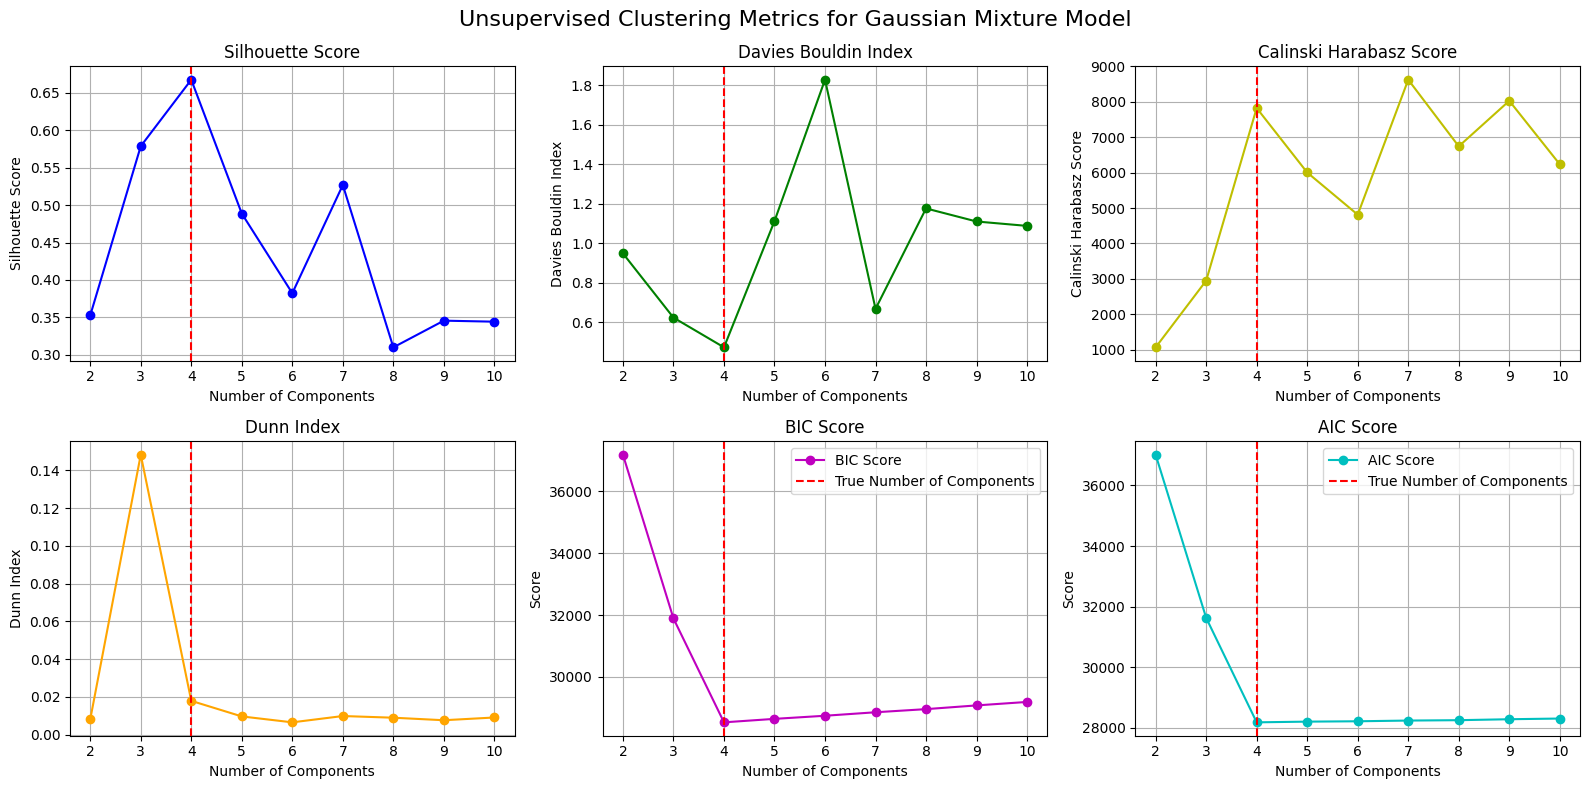

True number of components: 4
Ideal number of components based on Silhouette Score: 4
Ideal number of components based on Davies Bouldin Index: 4
Ideal number of components based on Calinski Harabasz Score: 7
Ideal number of components based on Dunn Index: 3
Ideal number of components based on BIC: 4
Ideal number of components based on AIC: 4


In [34]:
# Create 2 by 3 plot
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# Silhouette Score
ax[0, 0].plot(components_range, silhouette.cpu(), marker='o', color='b', label='Silhouette Score')
ax[0, 0].set_title('Silhouette Score')
ax[0, 0].set_xlabel('Number of Components')
ax[0, 0].set_ylabel('Silhouette Score')
ax[0, 0].grid(True)
ax[0, 0].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Davies Bouldin Index
ax[0, 1].plot(components_range, davies_bouldin.cpu(), marker='o', color='g', label='Davies Bouldin Index')
ax[0, 1].set_title('Davies Bouldin Index')
ax[0, 1].set_xlabel('Number of Components')
ax[0, 1].set_ylabel('Davies Bouldin Index')
ax[0, 1].grid(True)
ax[0, 1].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Calinski Harabasz Score
ax[0, 2].plot(components_range, calinski_harabasz.cpu(), marker='o', color='y', label='Calinski Harabasz Score')
ax[0, 2].set_title('Calinski Harabasz Score')
ax[0, 2].set_xlabel('Number of Components')
ax[0, 2].set_ylabel('Calinski Harabasz Score')
ax[0, 2].grid(True)
ax[0, 2].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# Dunn Index
ax[1, 0].plot(components_range, dunn_index.cpu(), marker='o', color='orange', label='Dunn Index')
ax[1, 0].set_title('Dunn Index')
ax[1, 0].set_xlabel('Number of Components')
ax[1, 0].set_ylabel('Dunn Index')
ax[1, 0].grid(True)
ax[1, 0].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')

# BIC Score
ax[1, 1].plot(components_range, bic.cpu(), marker='o', color='m', label='BIC Score')
ax[1, 1].set_title('BIC Score')
ax[1, 1].set_xlabel('Number of Components')
ax[1, 1].set_ylabel('Score')
ax[1, 1].grid(True)
ax[1, 1].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[1, 1].legend()

# AIC Score
ax[1, 2].plot(components_range, aic.cpu(), marker='o', color='c', label='AIC Score')
ax[1, 2].set_title('AIC Score')
ax[1, 2].set_xlabel('Number of Components')
ax[1, 2].set_ylabel('Score')
ax[1, 2].grid(True)
ax[1, 2].axvline(x=n_components, color='r', linestyle='--', label='True Number of Components')
ax[1, 2].legend()

plt.suptitle('Unsupervised Clustering Metrics for Gaussian Mixture Model', fontsize=16)
plt.tight_layout()
plt.legend()
plt.savefig(figure_folder + 'unsupervised_clustering_metrics_4d.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print ideal number of components
print(f'True number of components: {n_components}')
print(f'Ideal number of components based on Silhouette Score: {components_range[np.argmax(silhouette.cpu())]}')
print(f'Ideal number of components based on Davies Bouldin Index: {components_range[np.argmin(davies_bouldin.cpu())]}')
print(f'Ideal number of components based on Calinski Harabasz Score: {components_range[np.argmax(calinski_harabasz.cpu())]}')
print(f'Ideal number of components based on Dunn Index: {components_range[np.argmax(dunn_index.cpu())]}')
print(f'Ideal number of components based on BIC: {components_range[np.argmin(bic.cpu())]}')
print(f'Ideal number of components based on AIC: {components_range[np.argmin(aic.cpu())]}')


## KL Divergence

In [35]:
RUN_KL_DIVERGENCE = False

if RUN_KL_DIVERGENCE:
    gmm_true = GaussianMixture(
        n_features=n_features,
        n_components=n_components, 
        covariance_type='full',
        max_iter=max_iter,
        init_params=init_params,
        device=device,
        verbose=False,
        verbose_interval=1
    )
    gmm_true.fit(X_tensor.to(device))
    components_range = np.arange(1, 11)
    kl_divergence = torch.zeros(components_range.shape, device=device)

    # Loop over component range
    for i, n in tqdm(enumerate(components_range), total=len(components_range)):
        gmm = GaussianMixture(
            n_features=n_features,
            n_components=n,
            covariance_type='diag',
            max_iter=max_iter,
            init_params=init_params,
            device=device,
            verbose=False,
            verbose_interval=1
        )
        
        gmm.fit(X_tensor.to(device))
        
        # Compute KL divergence between the true GMM and the current GMM
        kl_divergence[i] = ClusteringMetrics.kl_divergence_gmm(gmm_true, gmm, n_samples=10000)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(components_range, kl_divergence.cpu().numpy(), marker='o', linestyle='-', color='b')
    ax.set_title('KL Divergence between True GMM and Fitted GMMs')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('KL Divergence')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()

    plt.savefig(figure_folder + 'kl_divergence.pdf', format='pdf', dpi=300, bbox_inches='tight')

    plt.show()

## Supervised Clustering metrics

In [36]:
import torch
from matplotlib.patches import Ellipse
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd

def match_labels(y_true, y_pred):
    # Create the contingency table
    contingency_matrix = torch.zeros((y_true.max() + 1, y_pred.max() + 1), dtype=torch.int32)
    for i in range(y_true.size(0)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    
    # Apply the Hungarian algorithm to find the best match between true and predicted labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.cpu().numpy())
    
    # Create a mapping from predicted to true labels
    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Apply the mapping to y_pred
    matched_labels = torch.tensor([label_mapping[label.item()] for label in y_pred], dtype=torch.int64)
    return matched_labels

def plot_clustering_pca(X, y_true, y_pred, means, covariances, ax, scores=None):
    y_pred = match_labels(y_true, y_pred)

    correct = y_true == y_pred
    incorrect = y_true != y_pred

    ax.scatter(X[correct][:, 0].cpu(), X[correct][:, 1].cpu(), c='lightblue', label='Correct prediction', s=5)
    ax.scatter(X[incorrect][:, 0].cpu(), X[incorrect][:, 1].cpu(), c='red', label='Incorrect prediction', s=5)

    for i in range(means.shape[0]):
        mean = means[i, :2].cpu().numpy()  # Only consider the first two dimensions
        cov = covariances[i, :2, :2].cpu().numpy()  # Only consider the 2x2 covariance matrix

        ax.scatter(mean[0], mean[1], c='black', marker='x')
        
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))  # Use two arguments

        width, height = 2 * np.sqrt(5.991 * eigvals)  # For 95% confidence ellipse
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        ax.add_patch(ell)

    ax.legend()
    ax.set_title('PCA Clustering Results')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

    # Display scores on the plot
    if scores is not None:
        score_text = '\n'.join([f"{metric}: {score:.2f}" for metric, score in scores.items()])
        ax.text(1.02, 0.5, score_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=1))


## Validity of the clustering metrics

In [37]:
def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)

def dunn(k_list):
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def numpy_purity_score(labels_true, labels_pred):
    contingency = np.zeros((np.max(labels_true) + 1, np.max(labels_pred) + 1))
    for i in range(len(labels_true)):
        contingency[labels_true[i], labels_pred[i]] += 1
    return np.sum(np.max(contingency, axis=0)) / len(labels_true)

In [38]:
gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full',
                      max_iter=max_iter, init_params=init_params, device=device)
gmm.fit(X_tensor)
y_pred = gmm.predict(X_tensor).to(X_tensor.device)

# Dictionary of clustering metrics
metrics = [
    "rand_score",
    "adjusted_rand_score",
    "mutual_info_score",
    "normalized_mutual_info_score",
    "adjusted_mutual_info_score",
    "fowlkes_mallows_score",
    "homogeneity_score",
    "completeness_score",
    "v_measure_score",
    "purity_score",
    "silhouette_score",
    "davies_bouldin_index",
    "calinski_harabasz_score",
    "dunn_index",
    "bic_score",
    "aic_score",
]

# Evaluate clustering with custom ClusteringMetrics
all_scores = gmm.evaluate_clustering(X_tensor, true_labels=y_tensor, metrics=metrics)

# Sklearn metrics for comparison
y_pred_np = y_pred.cpu().numpy()  # Move to CPU for sklearn
y_tensor_np = y_tensor.cpu().numpy()
X_tensor_np = X_tensor.cpu().numpy()

sklearn_scores = {
    "rand_score": rand_score(y_tensor_np, y_pred_np),
    "adjusted_rand_score": adjusted_rand_score(y_tensor_np, y_pred_np),
    "mutual_info_score": mutual_info_score(y_tensor_np, y_pred_np),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_tensor_np, y_pred_np),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_tensor_np, y_pred_np),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_tensor_np, y_pred_np),
    "homogeneity_score": homogeneity_score(y_tensor_np, y_pred_np),
    "completeness_score": completeness_score(y_tensor_np, y_pred_np),
    "v_measure_score": v_measure_score(y_tensor_np, y_pred_np),
    "silhouette_score": silhouette_score(X_tensor_np, y_pred_np),
    "davies_bouldin_index": davies_bouldin_score(X_tensor_np, y_pred_np),
    "calinski_harabasz_score": calinski_harabasz_score(X_tensor_np, y_pred_np)
}

# BIC and AIC comparisons
sklearn_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=max_iter, init_params=init_params)
sklearn_gmm.fit(X_tensor_np)
sklearn_bic = sklearn_gmm.bic(X_tensor_np)
torch_bic = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)
sklearn_aic = sklearn_gmm.aic(X_tensor_np)
torch_aic = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n_components, gmm.covariance_type)

# Purity score comparison
torch_purity = ClusteringMetrics.purity_score(y_tensor, y_pred)
numpy_purity = numpy_purity_score(y_tensor_np, y_pred_np)
print(f"Torch Purity: {torch_purity:.5f}, Numpy Purity: {numpy_purity:.5f}, difference: {abs(torch_purity - numpy_purity):.5f}")

# Output comparison
for metric, value in all_scores.items():
    if metric in sklearn_scores:
        print(f"{metric}: sklearn: {sklearn_scores[metric]:.5f}, torch: {value:.5f}, difference: {abs(sklearn_scores[metric] - value):.5f}")

print(f"Torch BIC: {torch_bic}, Sklearn BIC: {sklearn_bic}, difference: {abs(torch_bic - sklearn_bic)}")
print(f"Torch AIC: {torch_aic}, Sklearn AIC: {sklearn_aic}, difference: {abs(torch_aic - sklearn_aic)}")

# Compare Dunn Index
cluster_centers = [X_tensor[y_pred == i].mean(dim=0).to(X_tensor.device) for i in range(n_components)]
dunn_index_torch = dunn(cluster_centers)
torch_dunn = ClusteringMetrics.dunn_index(X_tensor, y_pred, n_components)
print(f"Torch Dunn Index: {torch_dunn:.5f}, Sklearn Dunn Index: {dunn_index_torch:.5f}, difference: {abs(torch_dunn - dunn_index_torch):.5f}")



Torch Purity: 0.99679, Numpy Purity: 0.99679, difference: 0.00000
rand_score: sklearn: 0.99635, torch: 0.99635, difference: 0.00000
adjusted_rand_score: sklearn: 0.99084, torch: 0.99084, difference: 0.00000
mutual_info_score: sklearn: 1.31391, torch: 1.31391, difference: 0.00000
adjusted_mutual_info_score: sklearn: 0.98519, torch: 0.98520, difference: 0.00001
normalized_mutual_info_score: sklearn: 0.98520, torch: 0.98520, difference: 0.00000
fowlkes_mallows_score: sklearn: 0.99336, torch: 0.99336, difference: 0.00000
homogeneity_score: sklearn: 0.98514, torch: 0.98513, difference: 0.00000
completeness_score: sklearn: 0.98527, torch: 0.98527, difference: 0.00000
v_measure_score: sklearn: 0.98520, torch: 0.98520, difference: 0.00000
silhouette_score: sklearn: 0.66744, torch: 0.66744, difference: 0.00000
davies_bouldin_index: sklearn: 0.47364, torch: 0.47364, difference: 0.00000
calinski_harabasz_score: sklearn: 7822.94918, torch: 7822.94775, difference: 0.00143
Torch BIC: 28528.86328125,

,Metric,Value
0,rand_score,0.996346
1,adjusted_rand_score,0.990842
2,mutual_info_score,1.313912
3,adjusted_mutual_info_score,0.985197
4,normalized_mutual_info_score,0.985204
5,fowlkes_mallows_score,0.993363
6,homogeneity_score,0.985135
7,completeness_score,0.985274
8,v_measure_score,0.985204
9,purity_score,0.996786


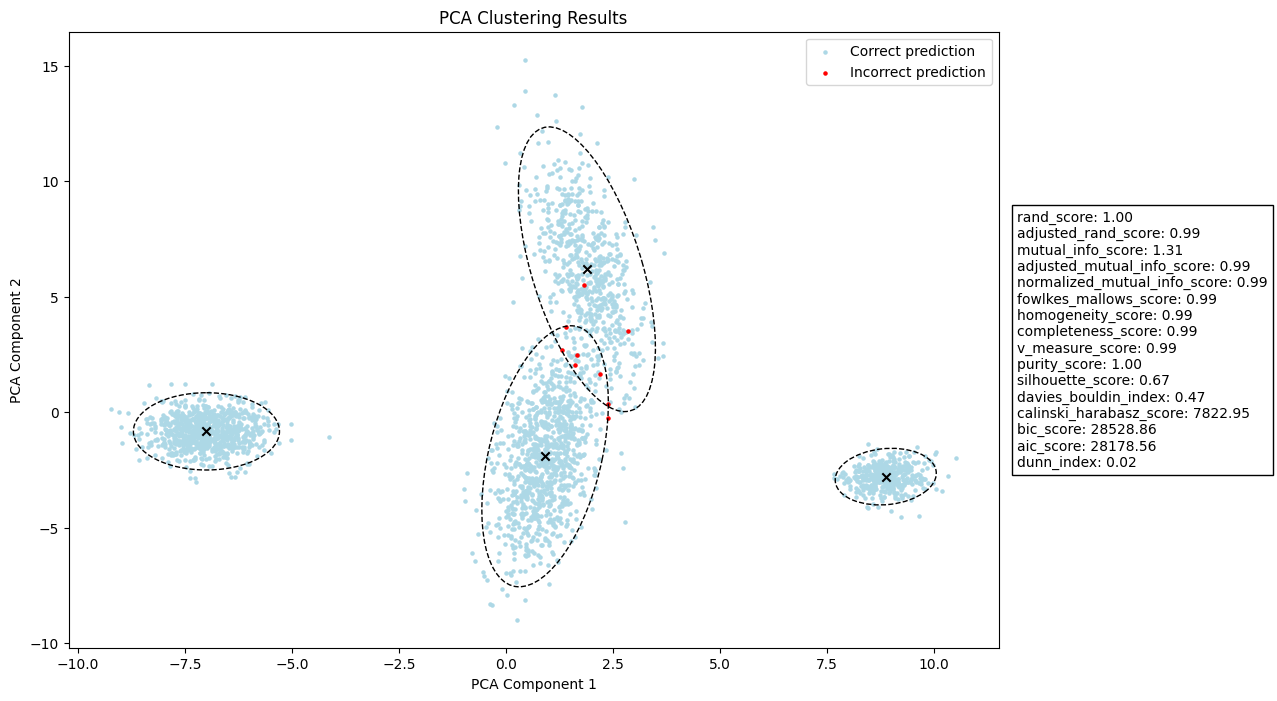

In [39]:
import torch
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

def transform_means_covariances(means, covariances, pca):
    """Transform means and covariances to the PCA-reduced space."""
    means_pca = pca.transform(means.cpu().numpy())  # Convert means to NumPy array and apply PCA transformation
    covariances_pca = []
    
    for cov in covariances.cpu().numpy():  # Convert each covariance matrix to NumPy array
        # Project the covariance matrix into the PCA space using the formula: A * Cov * A^T
        cov_pca = pca.components_ @ cov @ pca.components_.T
        covariances_pca.append(cov_pca[:2, :2])  # Only keep the 2D projection of the covariance
    
    return torch.tensor(means_pca, dtype=torch.float32), torch.tensor(covariances_pca, dtype=torch.float32)

def plot_clustering_pca(X, y_true, y_pred, means, covariances, ax, scores=None):
    """Plot the clustering results in PCA-reduced space."""
    y_pred = match_labels(y_true, y_pred)

    correct = y_true == y_pred
    incorrect = y_true != y_pred

    ax.scatter(X[correct][:, 0].cpu(), X[correct][:, 1].cpu(), c='lightblue', label='Correct prediction', s=5)
    ax.scatter(X[incorrect][:, 0].cpu(), X[incorrect][:, 1].cpu(), c='red', label='Incorrect prediction', s=5)

    for i in range(means.shape[0]):
        mean = means[i, :2].cpu().numpy()  # Only consider the first two dimensions
        cov = covariances[i].cpu().numpy()  # The covariance is already 2x2

        ax.scatter(mean[0], mean[1], c='black', marker='x')
        
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))  # Use two arguments

        width, height = 2 * np.sqrt(5.991 * eigvals)  # For 95% confidence ellipse
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        ax.add_patch(ell)

    ax.legend()
    ax.set_title('PCA Clustering Results')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

    # Display scores on the plot
    if scores is not None:
        score_text = '\n'.join([f"{metric}: {score:.2f}" for metric, score in scores.items()])
        ax.text(1.02, 0.5, score_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=1))


# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tensor.cpu())

# Transform means and covariances
means_pca, covariances_pca = transform_means_covariances(gmm.means_, gmm.covariances_, pca)

# Plotting with PCA-reduced data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_clustering_pca(torch.tensor(X_pca, dtype=torch.float32), y_tensor, y_pred, means_pca, covariances_pca, ax, all_scores)
plt.savefig(figure_folder + 'clustering_pca_4d.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Displaying the scores
df = pd.DataFrame(all_scores.items(), columns=['Metric', 'Value'])
df


Confusion Matrix:
tensor([[996,   0,   0,   4],
        [  0, 800,   0,   0],
        [  0,   0, 400,   0],
        [  5,   0,   0, 595]], dtype=torch.int32)
Classification Report:
{0: {'precision': 0.995004995004995, 'recall': 0.996, 'f1-score': 0.9955022488755622, 'support': 1000, 'jaccard': 0.991044776119403, 'roc_auc': 0.99549400806427}, 1: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 800, 'jaccard': 1.0, 'roc_auc': 1.0}, 2: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400, 'jaccard': 1.0, 'roc_auc': 1.0}, 3: {'precision': 0.993322203672788, 'recall': 0.9916666666666667, 'f1-score': 0.9924937447873228, 'support': 600, 'jaccard': 0.9850993377483444, 'roc_auc': 0.9971325993537903}}


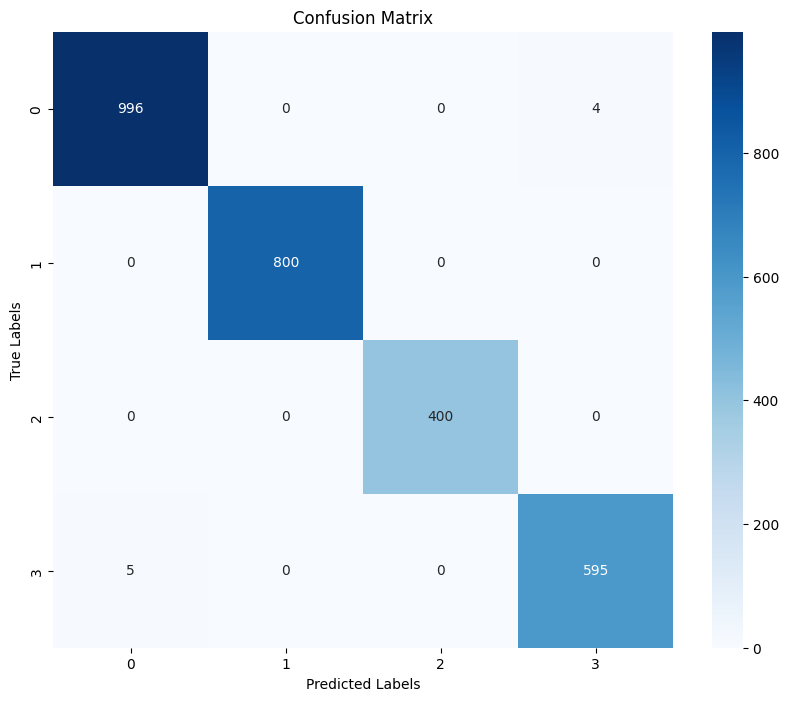

,precision,recall,f1-score,support,jaccard,roc_auc
0,0.995005,0.996000,0.995502,1000.0,0.991045,0.995494
1,1.000000,1.000000,1.000000,800.0,1.000000,1.000000
2,1.000000,1.000000,1.000000,400.0,1.000000,1.000000
3,0.993322,0.991667,0.992494,600.0,0.985099,0.997133


In [40]:
import seaborn as sns

y_pred = match_labels(y_tensor, y_pred)

# Get the confusion matrix
cm = ClusteringMetrics.confusion_matrix(y_tensor, y_pred)
print('Confusion Matrix:')
print(cm)

# Get the classification report
report = ClusteringMetrics.classification_report(y_tensor, y_pred)
print('Classification Report:')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a DataFrame from the classification report
report_df = pd.DataFrame(report).transpose()
# Display the DataFrame
report_df